# 数据预处理

## 导入数据

In [115]:
# 导入相关package
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import chardet

In [116]:
# 定义一个函数，自动检测文件编码并读取文件
def read_csv_with_detected_encoding(file_path):
    # 检测文件编码
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
        encoding = result['encoding']
        print(f"检测到文件 {file_path} 的编码格式为：{encoding}")
    # 使用检测到的编码读取文件
    return pd.read_csv(file_path, encoding=encoding)

# 读取 data_dictionary.csv 文件
csv_content = read_csv_with_detected_encoding('2025_Problem_C_Data\\data_dictionary.csv')
print("data_dictionary.csv 数据预览：")
print(csv_content.head())

# 读取 summerOly_medal_counts.csv 文件
medal_counts = read_csv_with_detected_encoding('2025_Problem_C_Data\\summerOly_medal_counts.csv')
print("\nsummerOly_medal_counts.csv 数据预览：")
print(medal_counts.head())

# 读取 summerOly_hosts.csv 文件
olympic_hosts = read_csv_with_detected_encoding('2025_Problem_C_Data\\summerOly_hosts.csv')
print("\nsummerOly_hosts.csv 数据预览：")
print(olympic_hosts.head())

# 读取 summerOly_programs.csv 文件
olympic_programs = read_csv_with_detected_encoding('2025_Problem_C_Data\\summerOly_programs.csv')
print("\nsummerOly_programs.csv 数据预览：")
print(olympic_programs.head())

# 读取 summerOly_athletes.csv 文件
olympic_athletes = read_csv_with_detected_encoding('2025_Problem_C_Data\\summerOly_athletes.csv')
print("\nsummerOly_athletes.csv 数据预览：")
print(olympic_athletes.head())

检测到文件 2025_Problem_C_Data\data_dictionary.csv 的编码格式为：Windows-1252
data_dictionary.csv 数据预览：
  summerOly_medal_counts.csv                                     Unnamed: 1  \
0                  variables                                    explanation   
1                       Rank      Rank of country based on total medals won   
2                        NOC  Name of country as recorded for that Olympics   
3                       Gold       Number of Gold medals the country earned   
4                     Silver     Number of Silver medals the country earned   

      Unnamed: 2  
0        example  
1           1, 2  
2  China, France  
3        0, 1, 2  
4        0, 1, 2  
检测到文件 2025_Problem_C_Data\summerOly_medal_counts.csv 的编码格式为：utf-8

summerOly_medal_counts.csv 数据预览：
   Rank            NOC  Gold  Silver  Bronze  Total  Year
0     1  United States    11       7       2     20  1896
1     2         Greece    10      18      19     47  1896
2     3        Germany     6       5       2 

## 数据清洗

### 缺失值检查

In [117]:
# 1. 缺失值检查
def check_missing_values(file_path):
    """
    检查 CSV 文件中的缺失值。

    参数:
        file_path (str): CSV 文件的路径。

    返回:
        None，但会打印缺失值的相关信息。
    """
    try:
        # 尝试读取 CSV 文件
        data = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        data = pd.read_csv(file_path, encoding='ISO-8859-1')

    print(file_path)

    # 检查每列的缺失值数量
    missing_values_per_column = data.isnull().sum()
    print("每列的缺失值数量：")
    print(missing_values_per_column)

    # 检查整个数据框的总缺失值数量
    total_missing_values = missing_values_per_column.sum()
    print("整个数据框的总缺失值数量：", total_missing_values)

    # 检查是否有任何缺失值
    has_missing_values = data.isnull().values.any()
    print("数据框中是否存在缺失值：", has_missing_values)
    print("\n")

    # 如果有缺失值，输出包含缺失值的行
    if has_missing_values:
        print("\n包含缺失值的行：")
        print(data[data.isnull().any(axis=1)])
    
content_name = ['2025_Problem_C_Data\\summerOly_medal_counts.csv', '2025_Problem_C_Data\\summerOly_hosts.csv', '2025_Problem_C_Data\\summerOly_programs.csv', '2025_Problem_C_Data\\summerOly_athletes.csv']
for i in content_name:
    check_missing_values(i)

2025_Problem_C_Data\summerOly_medal_counts.csv
每列的缺失值数量：
Rank      0
NOC       0
Gold      0
Silver    0
Bronze    0
Total     0
Year      0
dtype: int64
整个数据框的总缺失值数量： 0
数据框中是否存在缺失值： False


2025_Problem_C_Data\summerOly_hosts.csv
每列的缺失值数量：
Year    0
Host    0
dtype: int64
整个数据框的总缺失值数量： 0
数据框中是否存在缺失值： False


2025_Problem_C_Data\summerOly_programs.csv
每列的缺失值数量：
Sport                    0
Discipline               2
Code                     0
Sports Governing Body    0
1896                     0
1900                     0
1904                     0
1906*                    0
1908                     0
1912                     0
1920                     0
1924                     0
1928                     2
1932                     2
1936                     2
1948                     2
1952                     2
1956                     2
1960                     2
1964                     2
1968                     2
1972                     2
1976                     2
1980           

### 补全summerOly_programs.csv中的缺失值

In [118]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import re
import os

# 确保保存结果的目录存在
os.makedirs('Generated', exist_ok=True)

data = olympic_programs.copy()

# 3. 检查缺失值
#print("每列的缺失值数量：")
#print(data.isnull().sum())

# 4. 填充 Discipline 列的缺失值
data['Discipline'] = data['Discipline'].fillna(data['Sport'])

# 5. 准备年份列的数据
years = [col for col in data.columns if col.isdigit() or col.endswith('*')]

# 6. 将数据从宽格式转换为长格式
data_long = data.melt(id_vars=['Sport', 'Discipline', 'Code', 'Sports Governing Body'], 
                      value_vars=years, 
                      var_name='Year', 
                      value_name='Events')

# 7. 将年份列转换为数值
data_long['Year'] = data_long['Year'].str.replace('*', '').astype(int)

# 8. 清理 Events 列中的非数值字符
def clean_events(value):
    if isinstance(value, str):
        # 移除非数值字符
        cleaned_value = re.sub(r'[^0-9]', '', value)
        return float(cleaned_value) if cleaned_value.isdigit() else np.nan
    return value

data_long['Events'] = data_long['Events'].apply(clean_events)

# 9. 将1924年以及之后的 Skating 和 Ice Hockey 项目的赛事数目填为0
mask = (data_long['Year'] >= 1924) & (data_long['Sport'].isin(['Skating', 'Ice Hockey']))
data_long.loc[mask, 'Events'] = 0

# 10. 分组处理，按运动种类单独训练模型
for sport, group in data_long.groupby('Sport'):
    # 分离已知数据和缺失数据
    known_data = group.dropna(subset=['Events'])
    missing_data = group[group['Events'].isna()]
    
    if not known_data.empty and not missing_data.empty:
        # 准备训练数据
        X_known = known_data[['Year']]
        y_known = known_data['Events']
        
        # 检查已知数据的数量
        if len(y_known) < 5:
            print(f"警告：运动种类 '{sport}' 的已知数据太少，使用 KNN 或线性回归填充。")
            
            # 尝试使用线性回归
            if len(y_known) >= 3:  # 至少需要3个点来拟合线性回归
                model = LinearRegression()
                model.fit(X_known, y_known)
                predicted_events = model.predict(missing_data[['Year']])
            else:  # 使用 KNN，K=1
                model = KNeighborsRegressor(n_neighbors=1)
                model.fit(X_known, y_known)
                predicted_events = model.predict(missing_data[['Year']])
            
            # 将预测值四舍五入为整数
            predicted_events = np.round(predicted_events).astype(int)
            
            # 将预测值转换为 Pandas Series，并确保索引对齐
            predicted_series = pd.Series(predicted_events, index=missing_data.index)
            
            # 填充缺失值
            data_long.loc[data_long['Sport'] == sport, 'Events'] = data_long.loc[data_long['Sport'] == sport, 'Events'].fillna(predicted_series)
        else:
            # 训练随机森林模型
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_known, y_known)
            
            # 预测缺失数据
            X_missing = missing_data[['Year']]
            predicted_events = model.predict(X_missing)
            
            # 将预测值四舍五入为整数
            predicted_events = np.round(predicted_events).astype(int)
            
            # 将预测值转换为 Pandas Series，并确保索引对齐
            predicted_series = pd.Series(predicted_events, index=missing_data.index)
            
            # 填充缺失值
            data_long.loc[data_long['Sport'] == sport, 'Events'] = data_long.loc[data_long['Sport'] == sport, 'Events'].fillna(predicted_series)
            
            # 记录日志
            print(f"运动种类 '{sport}' 的模型训练完成，预测了 {len(predicted_events)} 个缺失值。")
    else:
        print(f"运动种类 '{sport}' 没有缺失数据或没有足够的已知数据。")

# 11. 将数据重新转换为宽格式
data_filled = data_long.pivot_table(index=['Sport', 'Discipline', 'Code', 'Sports Governing Body'], 
                                    columns='Year', 
                                    values='Events', 
                                    aggfunc='first').reset_index()

# 12. 输出结果
print("\n填充后的数据：")
print(data_filled.head())

# 13. 保存结果到新的 CSV 文件
output_path = 'Generated\\summerOly_programs_filled.csv'
data_filled.to_csv(output_path, index=False, encoding='utf-8')  # 确保保存时使用正确的编码
print(f"填充后的数据已保存到 {output_path}")

运动种类 'Aquatics' 没有缺失数据或没有足够的已知数据。
运动种类 'Archery' 没有缺失数据或没有足够的已知数据。
运动种类 'Athletics' 没有缺失数据或没有足够的已知数据。
运动种类 'Badminton' 的模型训练完成，预测了 2 个缺失值。
运动种类 'Baseball and Softball' 的模型训练完成，预测了 8 个缺失值。
运动种类 'Basketball' 的模型训练完成，预测了 2 个缺失值。
运动种类 'Basque Pelota' 的模型训练完成，预测了 4 个缺失值。
运动种类 'Boxing' 没有缺失数据或没有足够的已知数据。
运动种类 'Breaking' 没有缺失数据或没有足够的已知数据。
运动种类 'Canoeing' 的模型训练完成，预测了 1 个缺失值。
运动种类 'Cricket' 没有缺失数据或没有足够的已知数据。
运动种类 'Croquet' 没有缺失数据或没有足够的已知数据。
运动种类 'Cycling' 没有缺失数据或没有足够的已知数据。
运动种类 'Equestrian' 没有缺失数据或没有足够的已知数据。
运动种类 'Fencing' 没有缺失数据或没有足够的已知数据。
运动种类 'Field hockey' 没有缺失数据或没有足够的已知数据。
运动种类 'Flag football' 没有缺失数据或没有足够的已知数据。
运动种类 'Football' 没有缺失数据或没有足够的已知数据。
运动种类 'Golf' 没有缺失数据或没有足够的已知数据。
运动种类 'Gymnastics' 没有缺失数据或没有足够的已知数据。
运动种类 'Handball' 的模型训练完成，预测了 1 个缺失值。
运动种类 'Ice Hockey' 没有缺失数据或没有足够的已知数据。
运动种类 'Jeu de Paume' 没有缺失数据或没有足够的已知数据。
运动种类 'Judo' 没有缺失数据或没有足够的已知数据。
运动种类 'Karate' 没有缺失数据或没有足够的已知数据。
运动种类 'Lacrosse' 的模型训练完成，预测了 3 个缺失值。
运动种类 'Modern Pentathlon' 没有缺失数据或没有足够的已知数据。
运动种类 'Polo' 没有缺失数据或没有足够的已知数据。
运动种类 

### Medal_counts 数据清洗

In [119]:
# 2. 数据清洗
# 确保数据的格式正确
data = medal_counts[['Year', 'NOC', 'Gold', 'Silver', 'Bronze', 'Total']]

# 3. 创建年份和国家的索引
years = data['Year'].unique()
noc = data['NOC'].unique()

# 4. 定义一个函数来生成表格
def generate_table(data, column_name):
    # 创建一个空的 DataFrame，以年份为列，国家为行
    table = pd.DataFrame(index=noc, columns=years)
    
    # 填充数据
    for index, row in data.iterrows():
        year = row['Year']
        country = row['NOC']
        value = row[column_name]
        table.at[country, year] = value
    
    # 推断数据类型并填充缺失值为0
    table = table.infer_objects(copy=False).fillna(0).astype(int)
    
    return table

# 5. 生成金牌、银牌、铜牌和总数的表格
gold_table = generate_table(data, 'Gold')
silver_table = generate_table(data, 'Silver')
bronze_table = generate_table(data, 'Bronze')
total_table = generate_table(data, 'Total')

# 6. 保存到新的 CSV 文件
gold_table.to_csv('Generated\\summerOly_gold_summary.csv')
silver_table.to_csv('Generated\\summerOly_silver_summary.csv')
bronze_table.to_csv('Generated\\summerOly_bronze_summary.csv')
total_table.to_csv('Generated\\summerOly_total_summary.csv')

In [120]:
# 7. 输出结果
print("金牌表格：")
print(gold_table)

金牌表格：
                      1896  1900  1904  1908  1912  1920  1924  1928  1932  \
United States           11    19    76    23    26    41    45    22     0   
Greece                  10     0     1     0     1     0     0     0     0   
Germany                  6     4     4     3     5     0     0    10     0   
France                   5    27     0     5     7     9    13     6     0   
Great Britain            2    15     1    56    10    14     9     3     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
Saint Lucia              0     0     0     0     0     0     0     0     0   
Dominica                 0     0     0     0     0     0     0     0     0   
Albania                  0     0     0     0     0     0     0     0     0   
Cabo Verde               0     0     0     0     0     0     0     0     0   
Refugee Olympic Team     0     0     0     0     0     0     0     0     0   

                      1936  ...  1988  1992  1996  2000  

In [121]:
print("\n银牌表格：")
print(silver_table)


银牌表格：
                      1896  1900  1904  1908  1912  1920  1924  1928  1932  \
United States            7    14    78    12    19    27    27    18     0   
Greece                  18     0     0     3     0     1     0     0     0   
Germany                  5     3     5     5    13     0     0     7     0   
France                   4    39     1     5     4    19    15    10     0   
Great Britain            3     7     1    51    15    15    13    10     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
Saint Lucia              0     0     0     0     0     0     0     0     0   
Dominica                 0     0     0     0     0     0     0     0     0   
Albania                  0     0     0     0     0     0     0     0     0   
Cabo Verde               0     0     0     0     0     0     0     0     0   
Refugee Olympic Team     0     0     0     0     0     0     0     0     0   

                      1936  ...  1988  1992  1996  2000 

In [122]:
print("\n铜牌表格：")
print(bronze_table)


铜牌表格：
                      1896  1900  1904  1908  1912  1920  1924  1928  1932  \
United States            2    15    77    12    19    27    27    16     0   
Greece                  19     0     1     1     1     0     0     0     0   
Germany                  2     2     6     5     7     0     0    14     0   
France                   2    37     0     9     3    13    10     5     0   
Great Britain            2     9     0    39    16    13    12     7     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
Saint Lucia              0     0     0     0     0     0     0     0     0   
Dominica                 0     0     0     0     0     0     0     0     0   
Albania                  0     0     0     0     0     0     0     0     0   
Cabo Verde               0     0     0     0     0     0     0     0     0   
Refugee Olympic Team     0     0     0     0     0     0     0     0     0   

                      1936  ...  1988  1992  1996  2000 

In [123]:

print("\n总数表格：")
print(total_table)


总数表格：
                      1896  1900  1904  1908  1912  1920  1924  1928  1932  \
United States           20    48   231    47    64    95    99    56     0   
Greece                  47     0     2     4     2     1     0     0     0   
Germany                 13     9    15    13    25     0     0    31     0   
France                  11   103     1    19    14    41    38    21     0   
Great Britain            7    31     2   146    41    42    34    20     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
Saint Lucia              0     0     0     0     0     0     0     0     0   
Dominica                 0     0     0     0     0     0     0     0     0   
Albania                  0     0     0     0     0     0     0     0     0   
Cabo Verde               0     0     0     0     0     0     0     0     0   
Refugee Olympic Team     0     0     0     0     0     0     0     0     0   

                      1936  ...  1988  1992  1996  2000 

### 清理summerOly_medal_counts.csv异常值

In [124]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# 读取CSV文件
file_path = '2025_Problem_C_Data\\summerOly_medal_counts.csv'
data = pd.read_csv(file_path)

# 提取实际的奥运会年份
olympic_years = data['Year'].unique()
olympic_years = np.sort(olympic_years)  # 按年份排序
print("实际的奥运会年份：", olympic_years)

# 将数据按年份和国家分组
data['Year'] = data['Year'].astype(int)
data['NOC'] = data['NOC'].astype(str)
data = data[['Year', 'NOC', 'Gold', 'Silver', 'Bronze', 'Total']]

# 获取所有国家
countries = data['NOC'].unique()

# 创建一个完整的年份和国家组合的DataFrame
all_combinations = pd.MultiIndex.from_product([olympic_years, countries], names=['Year', 'NOC']).to_frame(index=False)

# 合并数据，填充缺失值为NaN（暂时不填充为0）
complete_data = pd.merge(all_combinations, data, on=['Year', 'NOC'], how='left')

# 计算每个国家首次参加奥运会的时间
first_participation = complete_data[complete_data['Total'] > 0].groupby('NOC')['Year'].min().reset_index()
first_participation.columns = ['NOC', 'First_Participation']
complete_data = pd.merge(complete_data, first_participation, on='NOC', how='left')

# 将每个国家在首次参加之前的所有年份的奖牌数填充为0
complete_data.loc[complete_data['Year'] < complete_data['First_Participation'], ['Gold', 'Silver', 'Bronze', 'Total']] = 0

# 将首次参加时间列删除，因为它已经不再需要
complete_data.drop(columns=['First_Participation'], inplace=True)

complete_data.to_csv('Generated\\summerOly_medal_counts_processed.csv')

# 定义一个函数来处理每个奖牌类型
def knn_impute(column_name):
    # 提取需要处理的列
    grouped = complete_data[['Year', 'NOC', column_name]].groupby('NOC')
    # 将分组结果转换为多个 DataFrame
    grouped_dfs = [group for noc, group in grouped]
    for df in grouped_dfs:
        current_noc = df['NOC'].iloc[0]  # 由于每个分组的 'NOC' 是相同的，可以直接取第一个值
        print(f"当前组的 NOC: {current_noc}")

        # 初始化 KNNImputer
        imputer = KNNImputer(n_neighbors=3, weights='distance')  # n_neighbors 是邻居数量，weights 可以选择 'uniform' 或 'distance'

        # 选择需要填充的列
        df_filled = imputer.fit_transform(df[['Year', column_name]])

        # 将结果转换回 DataFrame
        df_filled = pd.DataFrame(df_filled, columns=['Year', column_name])
        #print(df_filled)

        df_filled['Year'] = df_filled['Year'].astype(int)
        df_filled[column_name] = df_filled[column_name].round().astype(int)

        #print(df_filled)
        
        # 合并回原始数据
        #complete_data['NOC'==current_noc, column_name] = df_filled[column_name]
        for year in df_filled['Year']:
            index = df_filled[df_filled['Year'] == year].index[0]
            if complete_data.loc[(complete_data['NOC'] == current_noc) & (complete_data['Year'] == year), column_name].isna().any():
                # 如果存在 NaN 值，进行填充
                complete_data.loc[(complete_data['NOC'] == current_noc) & (complete_data['Year'] == year), column_name] = df_filled[column_name].iloc[index]

medal_list = ['Total', 'Gold', 'Silver', 'Bronze']

# 进行KNN补全
for medal in medal_list:
    knn_impute(medal)

# 保存处理后的数据为CSV文件
output_file = 'Generated\\summerOly_medal_counts_imputed.csv'
complete_data.to_csv(output_file, index=False)
print(f"处理后的数据已保存到 {output_file}")

实际的奥运会年份： [1896 1900 1904 1908 1912 1920 1924 1928 1932 1936 1948 1952 1956 1960
 1964 1968 1972 1976 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016
 2020 2024]
当前组的 NOC: Afghanistan
当前组的 NOC: Albania
当前组的 NOC: Algeria
当前组的 NOC: Argentina
当前组的 NOC: Argentina 
当前组的 NOC: Armenia
当前组的 NOC: Australasia
当前组的 NOC: Australia
当前组的 NOC: Australia 
当前组的 NOC: Austria
当前组的 NOC: Austria 
当前组的 NOC: Azerbaijan
当前组的 NOC: Bahamas
当前组的 NOC: Bahrain
当前组的 NOC: Barbados
当前组的 NOC: Belarus
当前组的 NOC: Belgium
当前组的 NOC: Belgium 
当前组的 NOC: Bermuda
当前组的 NOC: Bohemia
当前组的 NOC: Botswana
当前组的 NOC: Brazil
当前组的 NOC: Brazil 
当前组的 NOC: British West Indies 
当前组的 NOC: Bulgaria
当前组的 NOC: Bulgaria 
当前组的 NOC: Burkina Faso
当前组的 NOC: Burundi
当前组的 NOC: Cabo Verde
当前组的 NOC: Cameroon
当前组的 NOC: Canada
当前组的 NOC: Canada 
当前组的 NOC: Ceylon
当前组的 NOC: Chile
当前组的 NOC: China
当前组的 NOC: Chinese Taipei
当前组的 NOC: Colombia
当前组的 NOC: Costa Rica
当前组的 NOC: Croatia
当前组的 NOC: Cuba
当前组的 NOC: Cyprus
当前组的 NOC: Czech Republic
当前组的 NOC: Czechoslovaki

### 清理athletes.csv并转换格式为宽

In [125]:
# 读取 summerOly_athletes.csv 文件
data = olympic_athletes.copy()

# 转换为长格式，将年份放到列的抬头位置
pivot_df = data.pivot_table(index=['Name', 'Sex', 'Team', 'NOC', 'City', 'Sport', 'Event'], 
                                  columns='Year', 
                                  values='Medal',
                                  aggfunc='first').reset_index()

# 填充缺失值为0
pivot_df = pivot_df.fillna(0)

# 输出结果
print("转换为宽格式后的数据：")
print(pivot_df.head())

# 保存为新的 CSV 文件
output_path = 'Generated\\summerOly_athletes_wide_format.csv'
pivot_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"宽格式数据已保存到 {output_path}")

转换为宽格式后的数据：
Year           Name Sex          Team  NOC   City          Sport  \
0      (jr) Larocca   M     Argentina  ARG  Paris     Equestrian   
1     . Chadalavada   F         India  IND  Tokyo        Fencing   
2            . Deni   M     Indonesia  INA  Tokyo  Weightlifting   
3               671   F         China  CHN  Paris       Breaking   
4          A Alayed   F  Saudi Arabia  KSA  Paris       Swimming   

Year                     Event 1896 1900 1904  ... 1988 1992 1996 2000 2004  \
0           Jumping Individual    0    0    0  ...    0    0    0    0    0   
1     Women's Sabre Individual    0    0    0  ...    0    0    0    0    0   
2                   Men's 67kg    0    0    0  ...    0    0    0    0    0   
3                      B-Girls    0    0    0  ...    0    0    0    0    0   
4       Women's 200m Freestyle    0    0    0  ...    0    0    0    0    0   

Year 2008 2012 2016      2020      2024  
0       0    0    0         0  No medal  
1       0    0    0 

# 分析数据

## 国家级特征

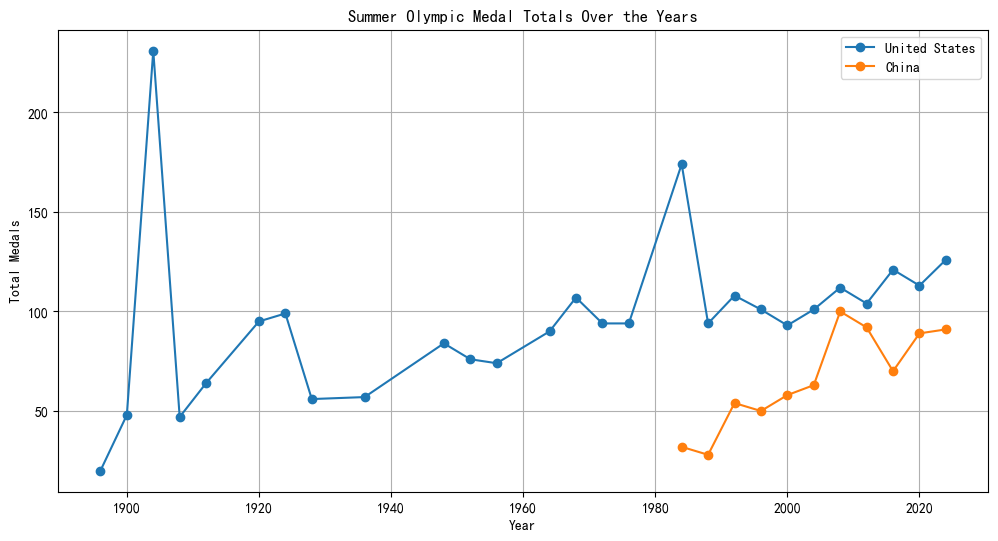

In [126]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
data = medal_counts.copy()

# 数据预处理
# 由于数据格式较为复杂，需要先将其转换为更易于处理的格式
# 提取年份和各个国家的奖牌总数
# 假设我们关注的是美国（United States）和中国的（China）奖牌总数
us_data = data[data['NOC'] == 'United States'][['Year', 'Total']].rename(columns={'Total': 'US_Total'})
china_data = data[data['NOC'] == 'China'][['Year', 'Total']].rename(columns={'Total': 'China_Total'})

# 合并数据
merged_data = pd.merge(us_data, china_data, on='Year', how='outer').sort_values(by='Year')

# 绘制折线图
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Year'], merged_data['US_Total'], label='United States', marker='o')
plt.plot(merged_data['Year'], merged_data['China_Total'], label='China', marker='o')

# 添加标题和图例
plt.title('Summer Olympic Medal Totals Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.legend()

# 显示网格
plt.grid(True)

# 显示图表
plt.show()

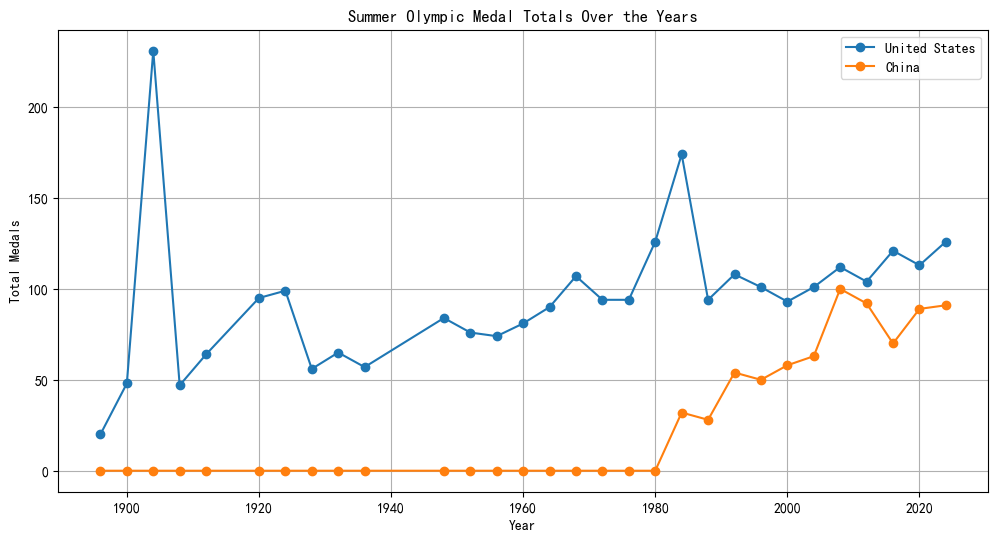

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv('Generated\\summerOly_medal_counts_imputed.csv')

# 数据预处理
# 由于数据格式较为复杂，需要先将其转换为更易于处理的格式
# 提取年份和各个国家的奖牌总数
# 假设我们关注的是美国（United States）和中国的（China）奖牌总数
us_data = data[data['NOC'] == 'United States'][['Year', 'Total']].rename(columns={'Total': 'US_Total'})
china_data = data[data['NOC'] == 'China'][['Year', 'Total']].rename(columns={'Total': 'China_Total'})

# 合并数据
merged_data = pd.merge(us_data, china_data, on='Year', how='outer').sort_values(by='Year')

# 绘制折线图
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Year'], merged_data['US_Total'], label='United States', marker='o')
plt.plot(merged_data['Year'], merged_data['China_Total'], label='China', marker='o')

# 添加标题和图例
plt.title('Summer Olympic Medal Totals Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.legend()

# 显示网格
plt.grid(True)

# 显示图表
plt.show()

## 项目级特征

## 运动员级特征

### 预处理

In [128]:
# 读取 summerOly_athletes.csv 文件
data = olympic_athletes.copy()

# 提取必要的列
athlete_years = olympic_athletes[['Name', 'Sex', 'NOC', 'Team', 'Year', 'Sport', 'Event']].drop_duplicates()
# 合并Name, Sex, NOC列
athlete_years['Feature'] = athlete_years['Name'] + ', ' + athlete_years['Sex']  + ', ' + athlete_years['NOC']

# 删除原始的Name, Sex, NOC列
#athlete_years = athlete_years.drop(columns=['Name', 'Sex', 'NOC'])

# 对每个运动员进行排序
athlete_years = athlete_years.sort_values(by=['Feature','Year'])
athlete_years.to_csv('Generated\\athlete_yesrs.csv', index=False, encoding='utf-8')

### 添加唯一特征值

In [129]:
import os

# 设置环境变量 LOKY_MAX_CPU_COUNT
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # 使用CPU 核心数

In [130]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# 读取CSV文件
file_path = 'Generated\\athlete_yesrs.csv'  # 替换为你的文件路径
data = pd.read_csv(file_path)

# 显示原始数据的前几行
print("原始数据的前几行：")
print(data.head())

# 设置时间阈值
time_threshold_small = 12
time_threshold_large = 44

# 按Feature分组
grouped = data.groupby('Feature')

# 用于存储处理后的数据
processed_data = []

# 遍历每个分组
for feature, group in grouped:
    # 按Year排序
    group = group.sort_values(by='Year')
    
    # 初始化变量
    unique_feature_count = 0
    last_year = None
    
    # 遍历分组中的每条记录
    for index, row in group.iterrows():
        current_year = row['Year']
        
        # 判断是否为同一个运动员
        if last_year is not None:
            year_diff = current_year - last_year
            if year_diff > time_threshold_large:
                # 如果时间跨度大于44年，直接认为是不同运动员
                unique_feature_count += 1
            elif year_diff > time_threshold_small:
                # 如果时间跨度在12到44年之间，进行聚类分析
                features_cluster = group[['Year', 'Sport', 'Event']].apply(lambda x: x.factorize()[0])
                features_cluster = StandardScaler().fit_transform(features_cluster)
                
                # 使用DBSCAN聚类
                dbscan = DBSCAN(eps=0.5, min_samples=2)
                group['Cluster'] = dbscan.fit_predict(features_cluster)
                
                # 为每个聚类生成唯一标识
                for cluster in group['Cluster'].unique():
                    cluster_group = group[group['Cluster'] == cluster]
                    for _, cluster_row in cluster_group.iterrows():
                        new_feature = f"{feature}_{cluster}"
                        processed_data.append({
                            'Name': cluster_row['Name'],
                            'Sex': cluster_row['Sex'],
                            'Team': cluster_row['Team'],
                            'NOC': cluster_row['NOC'],
                            'Year': cluster_row['Year'],
                            'Sport': cluster_row['Sport'],
                            'Event': cluster_row['Event'],
                            'Feature': new_feature
                        })
                        unique_feature_count += 1
                break  # 已经处理完当前分组，跳出循环
        
        # 如果时间跨度在阈值内，认为是同一个运动员
        new_feature = f"{feature}_{unique_feature_count}"
        processed_data.append({
            'Name': row['Name'],
            'Sex': row['Sex'],
            'Team': row['Team'],
            'NOC': row['NOC'],
            'Year': row['Year'],
            'Sport': row['Sport'],
            'Event': row['Event'],
            'Feature': new_feature
        })
        
        # 更新变量
        last_year = current_year

# 将处理后的数据转换为DataFrame
processed_df = pd.DataFrame(processed_data)

# 显示处理后的数据
print("\n处理后的数据：")
print(processed_df[['Feature', 'Sport', 'Event', 'Year']].head())

# 保存处理后的数据到新的CSV文件
output_file_path = 'Generated\\athlete_years_processed.csv'
processed_df.to_csv(output_file_path, index=False)
print(f"\n处理后的数据已保存到 {output_file_path}")

原始数据的前几行：
            Name Sex  NOC          Team  Year          Sport  \
0   (jr) Larocca   M  ARG     Argentina  2024     Equestrian   
1  . Chadalavada   F  IND         India  2020        Fencing   
2         . Deni   M  INA     Indonesia  2020  Weightlifting   
3            671   F  CHN         China  2024       Breaking   
4       A Alayed   F  KSA  Saudi Arabia  2024       Swimming   

                      Event                Feature  
0        Jumping Individual   (jr) Larocca, M, ARG  
1  Women's Sabre Individual  . Chadalavada, F, IND  
2                Men's 67kg         . Deni, M, INA  
3                   B-Girls            671, F, CHN  
4    Women's 200m Freestyle       A Alayed, F, KSA  

处理后的数据：
                   Feature          Sport                     Event  Year
0   (jr) Larocca, M, ARG_0     Equestrian        Jumping Individual  2024
1  . Chadalavada, F, IND_0        Fencing  Women's Sabre Individual  2020
2         . Deni, M, INA_0  Weightlifting               

### 统计连续参加奥运会的年数与对应人数

In [131]:
# 读取CSV文件
file_path = 'Generated\\athlete_years_processed.csv'  # 替换为你的文件路径
athlete_years = pd.read_csv(file_path)

In [132]:
# 计算连续参加的届数
def count_consecutive_years(group):
    years = group['Year'].sort_values().values
    consecutive_year = []
    current_count = 1
    for i in range(1, len(years)):
        if years[i] - years[i - 1] <= 6 :
            if years[i] - years[i - 1] >= 3:
                current_count += 1
        else:
            if current_count > 10:
                print(group)
            consecutive_year.append(current_count)
            current_count = 1
    consecutive_year.append(current_count)
    return pd.Series(consecutive_year)

# 应用函数计算每个运动员的连续届数
consecutive_years = athlete_years.groupby('Feature').apply(count_consecutive_years, include_groups=False).explode().reset_index()
consecutive_years.columns = ['Feature', 'level_0',  'Consecutive_Years']  # 修正列名
consecutive_years = consecutive_years.drop(columns=['level_0'])  # 删除不必要的列

# 统计每个连续届数的人数
consecutive_years_count = consecutive_years['Consecutive_Years'].value_counts().reset_index()
consecutive_years_count.columns = ['Consecutive_Years', 'Count']

# 输出结果
print("连续参加奥运会的届数与对应人次：")
print(consecutive_years_count)

# 保存为新的 CSV 文件
output_path = 'Generated\\consecutive_years_count.csv'
consecutive_years_count.to_csv(output_path, index=False, encoding='utf-8')
print(f"统计结果已保存到 {output_path}")

连续参加奥运会的届数与对应人次：
   Consecutive_Years   Count
0                  1  108202
1                  2   23470
2                  3    6036
3                  4    1575
4                  5     372
5                  6      79
6                  7      18
7                  8       4
8                  9       1
统计结果已保存到 Generated\consecutive_years_count.csv


#### 数据可视化

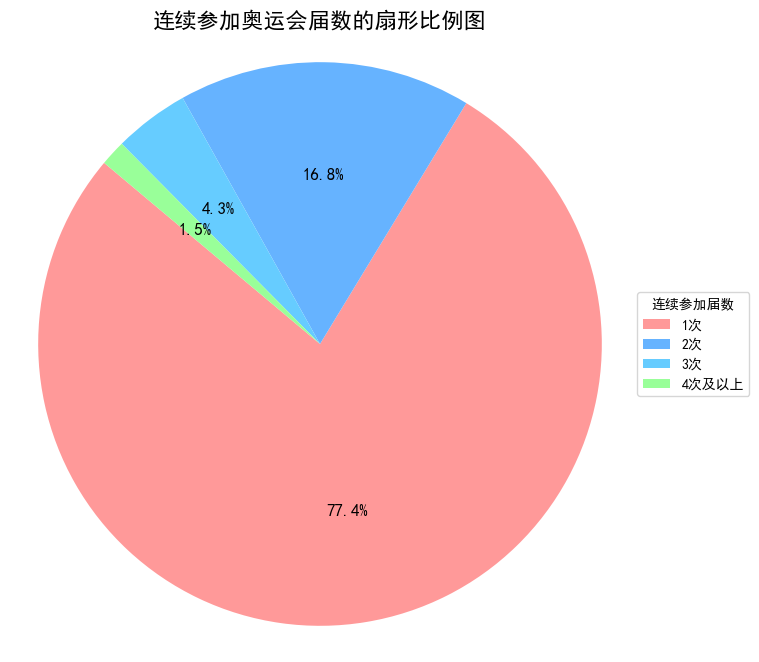

In [133]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 读取数据
data = pd.read_csv("Generated/consecutive_years_count.csv")

# 定义大致届数区间
bins = [0, 2, 3, 4, 14]
labels = ['1次', '2次', '3次', '4次及以上']

# 将数据分组到区间
data['Group'] = pd.cut(data['Consecutive_Years'], bins=bins, labels=labels, right=False)

# 计算每个区间的总人次，显式设置 observed=True
grouped_data = data.groupby('Group', observed=True)['Count'].sum().reset_index()

# 准备绘图数据
labels = grouped_data['Group']
sizes = grouped_data['Count']
colors = ['#ff9999', '#66b3ff', '#66ccff', '#99ff99']  # 颜色列表

# 绘制饼图
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})

# 添加图例（色块+标签），放置在右侧
plt.legend(wedges, labels, title="连续参加届数", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('连续参加奥运会届数的扇形比例图', fontsize=16)
plt.axis('equal')  # 确保饼图是圆形
plt.show()

In [134]:
# 保存组别与对应比例
group_percentages = []
for label, autotext in zip(labels, autotexts):
    # 获取百分比文本并去掉百分号，转换为浮点数
    percentage = float(autotext.get_text().strip('%'))
    group_percentages.append((label, percentage))

# 打印结果
print("组别与对应比例：")
for group, percentage in group_percentages:
    print(f"{group}: {percentage:.1f}%")

组别与对应比例：
1次: 77.4%
2次: 16.8%
3次: 4.3%
4次及以上: 1.5%


### 统计运动员参加奥运会的时间跨度

In [135]:
# 读取CSV文件
file_path = 'Generated\\athlete_years_processed.csv'  # 替换为你的文件路径
athlete_years = pd.read_csv(file_path)

In [136]:
# 计算每个运动员的第一次和最后一次参赛年份
def calculate_year_gap(group):
    years = group['Year'].values
    min_n = 2032
    max_n = 1896
    for i in years:
        if i < min_n:
            min_n = i
        if i > max_n:
            max_n = i
    if len(years) > 0:
        if max_n - min_n + 1 > 60:
            #print(group)
            return 1
        return max_n - min_n + 1
    else:
        return 0

# 应用函数计算每个运动员的间隔年数
athlete_gaps = athlete_years.groupby('Feature').apply(calculate_year_gap, include_groups=False).reset_index()
athlete_gaps.columns = ['Feature', 'Year_Gap']

# 统计每个间隔年数的人数
gap_counts = athlete_gaps['Year_Gap'].value_counts().reset_index()
gap_counts.columns = ['Year_Gap', 'Count']

# 按 Year_Gap 排序
gap_counts = gap_counts.sort_values(by='Year_Gap')

# 输出结果
print("运动员第一次参加奥运会和最后一次参加奥运会之间的间隔年数：")
print(gap_counts)

# 保存为新的 CSV 文件
output_path = 'Generated\\athlete_year_gaps.csv'
gap_counts.to_csv(output_path, index=False, encoding='utf-8')
print(f"统计结果已保存到 {output_path}")

运动员第一次参加奥运会和最后一次参加奥运会之间的间隔年数：
    Year_Gap  Count
0          1  99249
8          3     98
1          5  21869
10         7     77
2          9   8014
18        11     12
3         13   2887
15        15     16
4         17    942
19        19      8
5         21    382
20        23      3
6         25    178
21        27      1
7         29    134
22        31      1
9         33     90
11        37     57
12        41     49
24        43      1
13        45     44
14        49     21
17        53     12
16        57     13
23        59      1
统计结果已保存到 Generated\athlete_year_gaps.csv


#### 数据可视化

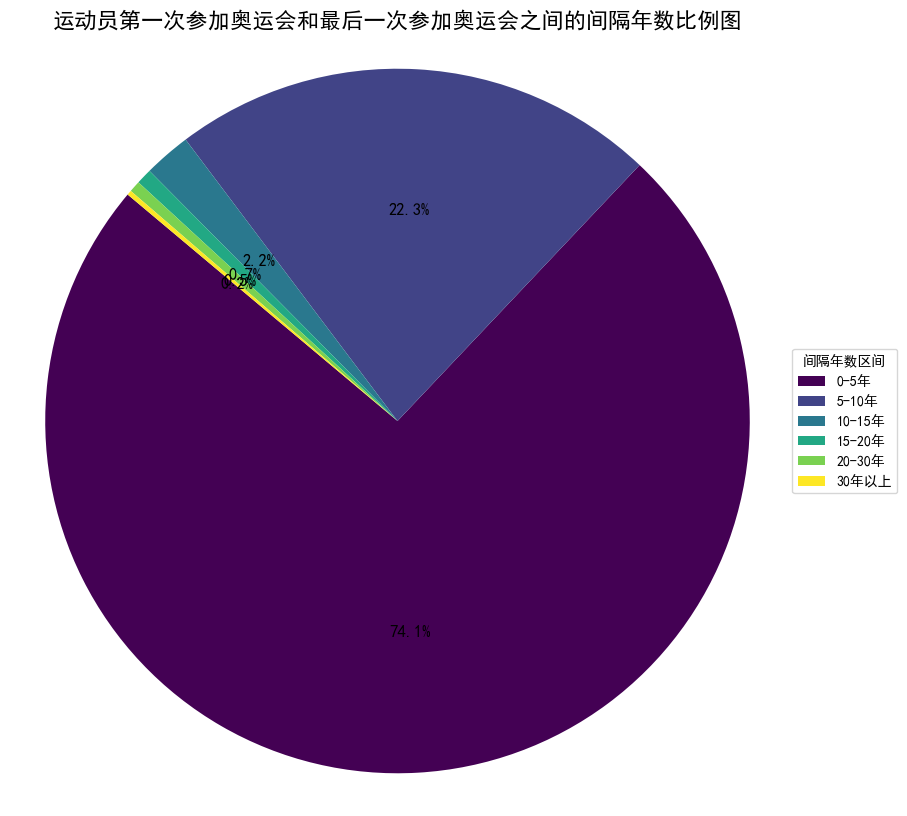

In [137]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 读取数据
data = pd.read_csv("Generated\\athlete_year_gaps.csv")

# 定义大致间隔年数区间
bins = [0, 5, 10, 15, 20, 30, 120]  # 区间划分：0-5年，5-10年，10-15年，15-20年，20-30年，30年以上
labels = ['0-5年', '5-10年', '10-15年', '15-20年', '20-30年', '30年以上']

# 将数据分组到区间
data['Group'] = pd.cut(data['Year_Gap'], bins=bins, labels=labels, right=False)

# 计算每个区间的总人次
grouped_data = data.groupby('Group', observed=True)['Count'].sum().reset_index()

# 准备绘图数据
labels = grouped_data['Group']
sizes = grouped_data['Count']
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))  # 使用颜色映射生成颜色列表

# 绘制饼图
plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})

# 添加图例（色块+标签），放置在右侧
plt.legend(wedges, labels, title="间隔年数区间", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('运动员第一次参加奥运会和最后一次参加奥运会之间的间隔年数比例图', fontsize=16)
plt.axis('equal')  # 确保饼图是圆形
plt.show()

'''根据扇形图，对于运动员连续参加比赛，只考虑连续参加2-3届的运动员的连续性影响，其余影响可以忽略不计。'''

#### 参加时间跨度为0-15年的运动员中连续参加的比例

In [138]:
# 合并时间跨度和连续届数数据
athlete_gaps.to_csv('Generated\\athlete_gaps.csv')
consecutive_years.to_csv('Generated\\consecutive_years.csv')
merged_data = athlete_gaps.merge(consecutive_years, on='Feature')

# 筛选出时间跨度为1-15年的运动员
filtered_data = merged_data[(merged_data['Year_Gap'] >= 1) & (merged_data['Year_Gap'] <= 15)]

# 统计连续参加的比例
total_count = filtered_data.shape[0]
consecutive_count = filtered_data[filtered_data['Year_Gap'] <= filtered_data['Consecutive_Years']*4].shape[0]
consecutive_ratio = consecutive_count / total_count if total_count > 0 else 0

# 输出结果
print(f"时间跨度为1-15年的运动员中，连续参加的比例为：{consecutive_ratio:.2%}")

# 保存结果到 CSV 文件
output_path = 'Generated\\consecutive_ratio.csv'
filtered_data.to_csv(output_path, index=False, encoding='utf-8')
print(f"统计结果已保存到 {output_path}")

时间跨度为1-15年的运动员中，连续参加的比例为：94.51%
统计结果已保存到 Generated\consecutive_ratio.csv


#### 数据可视化

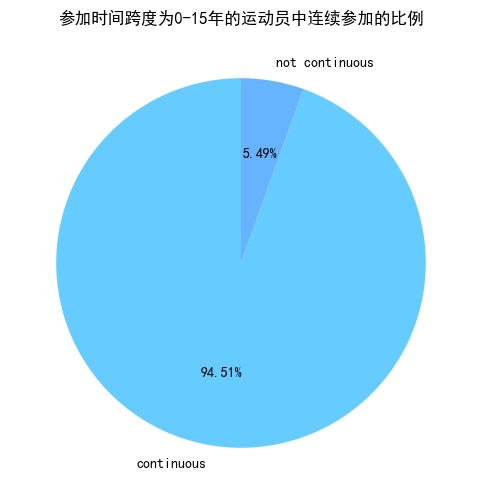

In [139]:
# 导入必要的库
import matplotlib.pyplot as plt

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 数据
percentages = [consecutive_ratio*100, (1-consecutive_ratio)*100]  # 一个百分数和剩余部分
labels = ['continuous', 'not continuous']  # 标签
colors = ['#66ccff', '#66b3ff']  # 颜色

# 绘制饼图
plt.figure(figsize=(6, 6))  # 设置图形大小
plt.pie(percentages, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
# autopct='%1.2f%%' 表示在每个扇形上显示百分比，格式为2位小数
# startangle=90 表示从90度（即正上方）开始绘制

# 添加标题
plt.title('参加时间跨度为0-15年的运动员中连续参加的比例')

# 显示图形
plt.show()

#### 结论
- '我们可以发现，参加奥运会时间跨度0-15年中绝大部分运动员都是连续参加的'
- '而且我们前面发现，绝大部分的运动员的时间跨度在0-15年之间，连续参加届数在1-3届'
- '而且我们知道，0-15之间只能连续参加1-3次奥运会'
- '我们因此可以得出结论，绝大部分奥运会运动员连续参加了1-3次奥运会'
- '所以我们可以得出结论，考虑运动员连续参加比赛对奖牌的影响只需要考虑连续参加2-3次的情况'

In [140]:
first_percentage = group_percentages[1][1]/(group_percentages[0][1]+group_percentages[1][1]+group_percentages[2][1]+group_percentages[3][1])*100
print(f'一个参加了一次奥运会的运动员参加下一次奥运会的可能为{first_percentage : .2f}' + '%')
second_percentage = group_percentages[2][1]/(group_percentages[1][1]+group_percentages[2][1]+group_percentages[3][1])*100
print(f'一个参加了两次奥运会的运动员参加下一次奥运会的可能为{second_percentage : .2f}' + '%')
third_percentage = group_percentages[3][1]/(group_percentages[2][1]+group_percentages[3][1])*100
print(f'一个参加了三次奥运会的运动员参加下一次奥运会的可能为{third_percentage : .2f}' + '%')
athlete_join_willing = {1 : first_percentage, 2 : second_percentage, 3 : third_percentage}

一个参加了一次奥运会的运动员参加下一次奥运会的可能为 16.80%
一个参加了两次奥运会的运动员参加下一次奥运会的可能为 19.03%
一个参加了三次奥运会的运动员参加下一次奥运会的可能为 25.86%


# 构建模型